<a href="https://colab.research.google.com/github/liuyao12/ConvNets-PDE-perspective/blob/main/Inception_ResNet_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 5: Inception, ResNet and DenseNet

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)


**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.ipynb)   
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial5)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1zOgLKmYJ2V3uHz57nPUMY6tq15RmEtNg?usp=sharing)   
**Recordings:** 
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/vjSSyGxlczs)
[![YouTube - Part 2](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%202&color=red)](https://youtu.be/9yRXqYJDHr4)
[![YouTube - Part 3](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%203&color=red)](https://youtu.be/ELEqNwv9vkE)   
**JAX+Flax version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** Interested in JAX? Check out our [JAX+Flax version](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html) of this tutorial!
</div>

In this tutorial, we will implement and discuss variants of modern CNN architectures. There have been many different architectures been proposed over the past few years. Some of the most impactful ones, and still relevant today, are the following: [GoogleNet](https://arxiv.org/abs/1409.4842)/Inception architecture (winner of ILSVRC 2014), [ResNet](https://arxiv.org/abs/1512.03385) (winner of ILSVRC 2015), and [DenseNet](https://arxiv.org/abs/1608.06993) (best paper award CVPR 2017). All of them were state-of-the-art models when being proposed, and the core ideas of these networks are the foundations for most current state-of-the-art architectures. Thus, it is important to understand these architectures in detail and learn how to implement them. 

Let's start with importing our standard libraries here.

In [1]:
## Standard libraries
import os
import numpy as np 
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [2]:
torch.cuda.is_available()

True

We will use the same `set_seed` function as in the previous tutorials, as well as the path variables `DATASET_PATH` and `CHECKPOINT_PATH`. Adjust the paths if necessary.

In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial5"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

We also have pretrained models and Tensorboards (more on this later) for this tutorial, and download them below.

In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "ResNetPreAct.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

Throughout this tutorial, we will train and evaluate the models on the CIFAR10 dataset. This allows you to compare the results obtained here with the model you have implemented in the first assignment. As we have learned from the previous tutorial about initialization, it is important to have the data preprocessed with a zero mean. Therefore, as a first step, we will calculate the mean and standard deviation of the CIFAR dataset:

In [5]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


We will use this information to define a `transforms.Normalize` module which will normalize our data accordingly. Additionally, we will use data augmentation during training. This reduces the risk of overfitting and helps CNNs to generalize better. Specifically, we will apply two random augmentations. 

First, we will flip each image horizontally by a chance of 50% (`transforms.RandomHorizontalFlip`). The object class usually does not change when flipping an image, and we don't expect any image information to be dependent on the horizontal orientation. This would be however different if we would try to detect digits or letters in an image, as those have a certain orientation.

The second augmentation we use is called `transforms.RandomResizedCrop`. This transformation scales the image in a small range, while eventually changing the aspect ratio, and crops it afterward in the previous size. Therefore, the actual pixel values change while the content or overall semantics of the image stays the same. 

We will randomly split the training dataset into a training and a validation set. The validation set will be used for determining early stopping. After finishing the training, we test the models on the CIFAR test set.

In [6]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


To verify that our normalization works, we can print out the mean and standard deviation of the single batch. The mean should be close to 0 and the standard deviation close to 1 for each channel:

In [7]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


Finally, let's visualize a few images from the training set, and how they look like after random data augmentation: 

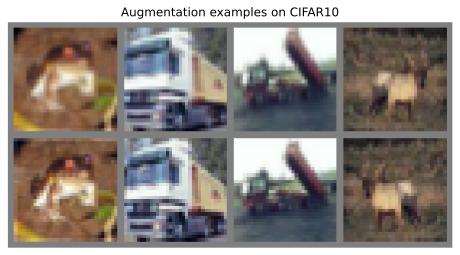

In [8]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## PyTorch Lightning

In this notebook and in many following ones, we will make use of the library [PyTorch Lightning](https://www.pytorchlightning.ai/). PyTorch Lightning is a framework that simplifies your code needed to train, evaluate, and test a model in PyTorch. It also handles logging into [TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html), a visualization toolkit for ML experiments, and saving model checkpoints automatically with minimal code overhead from our side. This is extremely helpful for us as we want to focus on implementing different model architectures and spend little time on other code overhead. Note that at the time of writing/teaching, the framework has been released in version 1.6. Future versions might have a slightly changed interface and thus might not work perfectly with the code (we will try to keep it up-to-date as much as possible). 

Now, we will take the first step in PyTorch Lightning, and continue to explore the framework in our other tutorials. First, we import the library:

In [9]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.5
    import pytorch_lightning as pl

PyTorch Lightning comes with a lot of useful functions, such as one for setting the seed:

In [10]:
# Setting the seed
pl.seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

Thus, in the future, we don't have to define our own `set_seed` function anymore. 

In PyTorch Lightning, we define `pl.LightningModule`'s (inheriting from `torch.nn.Module`) that organize our code into 5 main sections: 

1. Initialization (`__init__`), where we create all necessary parameters/models
2. Optimizers (`configure_optimizers`) where we create the optimizers, learning rate scheduler, etc. 
3. Training loop (`training_step`) where we only have to define the loss calculation for a single batch (the loop of optimizer.zero_grad(), loss.backward() and optimizer.step(), as well as any logging/saving operation, is done in the background)
4. Validation loop (`validation_step`) where similarly to the training, we only have to define what should happen per step
5. Test loop (`test_step`) which is the same as validation, only on a test set.

Therefore, we don't abstract the PyTorch code, but rather organize it and define some default operations that are commonly used. If you need to change something else in your training/validation/test loop, there are many possible functions you can overwrite (see the [docs](https://pytorch-lightning.readthedocs.io/en/stable/lightning_module.html) for details).

Now we can look at an example of how a Lightning Module for training a CNN looks like:

In [11]:
class CIFARModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

We see that the code is organized and clear, which helps if someone else tries to understand your code. 

Another important part of PyTorch Lightning is the concept of callbacks. Callbacks are self-contained functions that contain the non-essential logic of your Lightning Module. They are usually called after finishing a training epoch, but can also influence other parts of your training loop. For instance, we will use the following two pre-defined callbacks: `LearningRateMonitor` and `ModelCheckpoint`. The learning rate monitor adds the current learning rate to our TensorBoard, which helps to verify that our learning rate scheduler works correctly. The model checkpoint callback allows you to customize the saving routine of your checkpoints. For instance, how many checkpoints to keep, when to save, which metric to look out for, etc. We import them below:

In [12]:
# Callbacks 
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

To allow running multiple different models with the same Lightning module, we define a function below that maps a model name to the model class. At this stage, the dictionary `model_dict` is empty, but we will fill it throughout the notebook with our new models.

In [13]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

Similarly, to use the activation function as another hyperparameter in our model, we define a "name to function" dict below:

In [14]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

If we pass the classes or objects directly as an argument to the Lightning module, we couldn't take advantage of PyTorch Lightning's automatically hyperparameter saving and loading.

Besides the Lightning module, the second most important module in PyTorch Lightning is the `Trainer`. The trainer is responsible to execute the training steps defined in the Lightning module and completes the framework. Similar to the Lightning module, you can override any key part that you don't want to be automated, but the default settings are often the best practice to do. For a full overview, see the [documentation](https://pytorch-lightning.readthedocs.io/en/stable/trainer.html). The most important functions we use below are:

* `trainer.fit`: Takes as input a lightning module, a training dataset, and an (optional) validation dataset. This function trains the given module on the training dataset with occasional validation (default once per epoch, can be changed)
* `trainer.test`: Takes as input a model and a dataset on which we want to test. It returns the test metric on the dataset.

For training and testing, we don't have to worry about things like setting the model to eval mode (`model.eval()`) as this is all done automatically. See below how we define a training function for our models:

In [15]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name
        
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         gpus=1 if str(device)=="cuda:0" else 0,                                             # We run on a single GPU (if possible)
                         max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         enable_progress_bar=True)                                                           # Set to False if you do not want a progress bar
    trainer.logger._log_graph = False         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if False: # os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
        
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    
    return model, result

Finally, we can focus on the Convolutional Neural Networks we want to implement today: GoogleNet, ResNet, and DenseNet.

## Inception

The [GoogleNet](https://arxiv.org/abs/1409.4842), proposed in 2014, won the ImageNet Challenge because of its usage of the Inception modules. In general, we will mainly focus on the concept of Inception in this tutorial instead of the specifics of the GoogleNet, as based on Inception, there have been many follow-up works ([Inception-v2](https://arxiv.org/abs/1512.00567), [Inception-v3](https://arxiv.org/abs/1512.00567), [Inception-v4](https://arxiv.org/abs/1602.07261), [Inception-ResNet](https://arxiv.org/abs/1602.07261),...). The follow-up works mainly focus on increasing efficiency and enabling very deep Inception networks. However, for a fundamental understanding, it is sufficient to look at the original Inception block. 

An Inception block applies four convolution blocks separately on the same feature map: a 1x1, 3x3, and 5x5 convolution, and a max pool operation. This allows the network to look at the same data with different receptive fields. Of course, learning only 5x5 convolution would be theoretically more powerful. However, this is not only more computation and memory heavy but also tends to overfit much easier. The overall inception block looks like below (figure credit - [Szegedy et al.](https://arxiv.org/abs/1409.4842)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/inception_block.svg?raw=1" style="display: block; margin-left: auto; margin-right: auto;" width="500px"/></center>

The additional 1x1 convolutions before the 3x3 and 5x5 convolutions are used for dimensionality reduction. This is especially crucial as the feature maps of all branches are merged afterward, and we don't want any explosion of feature size. As 5x5 convolutions are 25 times more expensive than 1x1 convolutions, we can save a lot of computation and parameters by reducing the dimensionality before the large convolutions.

We can now try to implement the Inception Block ourselves:

In [ ]:
class InceptionBlock(nn.Module):
    
    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        
        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )
        
        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )
        
        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )
        
        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

The GoogleNet architecture consists of stacking multiple Inception blocks with occasional max pooling to reduce the height and width of the feature maps. The original GoogleNet was designed for image sizes of ImageNet (224x224 pixels) and had almost 7 million parameters. As we train on CIFAR10 with image sizes of 32x32, we don't require such a heavy architecture, and instead, apply a reduced version. The number of channels for dimensionality reduction and output per filter (1x1, 3x3, 5x5, and max pooling) need to be manually specified and can be changed if interested. The general intuition is to have the most filters for the 3x3 convolutions, as they are powerful enough to take the context into account while requiring almost a third of the parameters of the 5x5 convolution. 

In [ ]:
class GoogleNet(nn.Module):

    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

Now, we can integrate our model to the model dictionary we defined above:

In [ ]:
model_dict["GoogleNet"] = GoogleNet

The training of the model is handled by PyTorch Lightning, and we just have to define the command to start. Note that we train for almost 200 epochs, which takes about an hour on Lisa's default GPUs (GTX1080Ti). We would recommend using the saved models and train your own model if you are interested. 

In [ ]:
googlenet_model, googlenet_results = train_model(model_name="GoogleNet", 
                                                 model_hparams={"num_classes": 10, 
                                                                "act_fn_name": "relu"}, 
                                                 optimizer_name="Adam",
                                                 optimizer_hparams={"lr": 1e-3,
                                                                    "weight_decay": 1e-4})

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/GoogleNet.ckpt, loading...


We will compare the results later in the notebooks, but we can already print them here for a first glance:

In [ ]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'test': 0.8970000147819519, 'val': 0.9039999842643738}


### Tensorboard log

A nice extra of PyTorch Lightning is the automatic logging into TensorBoard. To give you a better intuition of what TensorBoard can be used, we can look at the board that PyTorch Lightning has been generated when training the GoogleNet. TensorBoard provides an inline functionality for Jupyter notebooks, and we use it here:

In [ ]:
# Load tensorboard extension
%load_ext tensorboard

In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir ../saved_models/tutorial5/tensorboards/GoogleNet/

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/tensorboard_screenshot_GoogleNet.png?raw=1" width="1000px"></center>

TensorBoard is organized in multiple tabs. The main tab is the scalar tab where we can log the development of single numbers. For example, we have plotted the training loss, accuracy, learning rate, etc. If we look at the training or validation accuracy, we can really see the impact of using a learning rate scheduler. Reducing the learning rate gives our model a nice increase in training performance. Similarly, when looking at the training loss, we see a sudden decrease at this point. However, the high numbers on the training set compared to validation indicate that our model was overfitting which is inevitable for such large networks.

Another interesting tab in TensorBoard is the graph tab. It shows us the network architecture organized by building blocks from the input to the output. It basically shows the operations taken in the forward step of `CIFARModule`. Double-click on a module to open it. Feel free to explore the architecture from a different perspective. The graph visualization can often help you to validate that your model is actually doing what it is supposed to do, and you don't miss any layers in the computation graph.

## ResNet

The [ResNet](https://arxiv.org/abs/1512.03385) paper is one of the  [most cited AI papers](https://www.natureindex.com/news-blog/google-scholar-reveals-most-influential-papers-research-citations-twenty-twenty), and has been the foundation for neural networks with more than 1,000 layers. Despite its simplicity, the idea of residual connections is highly effective as it supports stable gradient propagation through the network. Instead of modeling $x_{l+1}=F(x_{l})$, we model $x_{l+1}=x_{l}+F(x_{l})$ where $F$ is a non-linear mapping (usually a sequence of NN modules likes convolutions, activation functions, and normalizations). If we do backpropagation on such residual connections, we obtain:

$$\frac{\partial x_{l+1}}{\partial x_{l}} = \mathbf{I} + \frac{\partial F(x_{l})}{\partial x_{l}}$$

The bias towards the identity matrix guarantees a stable gradient propagation being less effected by $F$ itself. There have been many variants of ResNet proposed, which mostly concern the function $F$, or operations applied on the sum. In this tutorial, we look at two of them: the original ResNet block, and the [Pre-Activation ResNet block](https://arxiv.org/abs/1603.05027). We visually compare the blocks below (figure credit - [He et al.](https://arxiv.org/abs/1603.05027)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/resnet_block.svg?raw=1" style="display: block; margin-left: auto; margin-right: auto;" width="300px"/></center>

The original ResNet block applies a non-linear activation function, usually ReLU, after the skip connection. In contrast, the pre-activation ResNet block applies the non-linearity at the beginning of $F$. Both have their advantages and disadvantages. For very deep network, however, the pre-activation ResNet has shown to perform better as the gradient flow is guaranteed to have the identity matrix as calculated above, and is not harmed by any non-linear activation applied to it. For comparison, in this notebook, we implement both ResNet types as shallow networks.

Let's start with the original ResNet block. The visualization above already shows what layers are included in $F$. One special case we have to handle is when we want to reduce the image dimensions in terms of width and height. The basic ResNet block requires $F(x_{l})$ to be of the same shape as $x_{l}$. Thus, we need to change the dimensionality of $x_{l}$ as well before adding to $F(x_{l})$. The original implementation used an identity mapping with stride 2 and padded additional feature dimensions with 0. However, the more common implementation is to use a 1x1 convolution with stride 2 as it allows us to change the feature dimensionality while being efficient in parameter and computation cost. The code for the ResNet block is relatively simple, and shown below:

In [16]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )

        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

The second block we implement is the pre-activation ResNet block. For this, we have to change the order of layer in `self.net`, and do not apply an activation function on the output. Additionally, the downsampling operation has to apply a non-linearity as well as the input, $x_l$, has not been processed by a non-linearity yet. Hence, the block looks as follows:

In [17]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in
            
        # Network representing F
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )
        
        # 1x1 convolution needs to apply non-linearity as well as not done on skip connection
        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

In [18]:
class NewBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        self.c_in = c_in
        if not subsample:
            c_out = c_in
        self.c_out = c_out
            
        # self.conv = nn.Conv2d(1, 4, kernel_size=3, padding=1, groups=1, stride=1 if not subsample else 2, bias=False)
        self.conv = nn.Conv2d(c_in, c_in*4, kernel_size=3, padding=1, groups=c_in, stride=1 if not subsample else 2, bias=False)

        self.XY = None
        self.mix = nn.Conv2d(5, c_in*4, kernel_size=1, bias=True)
        self.net = nn.Sequential(
            nn.Conv2d(c_in*4, c_in*4, kernel_size=1, groups=1, bias=False),
            nn.BatchNorm2d(c_in*4),
            act_fn(),
            nn.Conv2d(c_in*4, c_out, kernel_size=1, 
                      # groups=2 if not subsample else 1, 
                      bias=False),
            nn.BatchNorm2d(c_out)
        )
        
        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        # self.padding1 = nn.ZeroPad2d(1)
        # self.padding2 = nn.ReplicationPad2d(1)
        self.act_fn = act_fn()

    def conv_forward(self, x, c):
        kernel = self.conv.weight.repeat(c,1,1,1)
        # kernel = torch.repeat_interleave(self.conv.weight, repeats=2*c, dim=0)
        # wt = self.conv.weight
        # kernel = torch.stack([wt, wt.transpose(2,3).flip(3)], dim=1).reshape(c*8,-1,3,3)
        return F.conv2d(x, kernel, self.conv.bias, self.conv.stride, self.conv.padding, self.conv.dilation, c)

    def forward(self, x):
        # z = self.conv_forward(x, self.c_in)
        z = self.conv(x)
        N, C, H, W = z.size()
        if self.XY is None: # or self.XY.size()[2] != z.size()[2]:
            # _, _, H, W = z.size()
            XX = torch.Tensor(np.indices((1,1,H,W))[3]*2/(W-1)-1)
            YY = torch.Tensor(np.indices((1,1,H,W))[2]*2/(H-1)-1)
            ones = torch.ones((1,1,H,W))
            self.XY = torch.cat([XX, YY, XX*XX, XX*YY, YY*YY],
                                dim=1).type(z.dtype).to(z.device)
            print("initialize self.XY:", self.XY.size())
        z = self.mix(self.XY) * z
        # z = z.view(N, -1, 2, H, W).sum(dim=2) / 2
        # z = z + torch.roll(z, 1, 2)
        z = self.net(z)
        # print(z.size(), x.size())
        if self.downsample is not None:
            x = self.downsample(x)
        out = (z + x) # [:,:,1:-1,1:-1]
        # out1 = self.padding1(out[:,:self.c_out//2,:,:])
        # out2 = self.padding2(out[:,self.c_out//2:,:,:])
        # out = torch.cat((out1, out2), 1)
        out = self.act_fn(out)
        return out

Similarly to the model selection, we define a dictionary to create a mapping from string to block class. We will use the string name as hyperparameter value in our model to choose between the ResNet blocks. Feel free to implement any other ResNet block type and add it here as well.

In [19]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock,
    "PreActResNetBlock": PreActResNetBlock,
    "NewBlock": NewBlock
}

The overall ResNet architecture consists of stacking multiple ResNet blocks, of which some are downsampling the input. When talking about ResNet blocks in the whole network, we usually group them by the same output shape. Hence, if we say the ResNet has `[3,3,3]` blocks, it means that we have 3 times a group of 3 ResNet blocks, where a subsampling is taking place in the fourth and seventh block. The ResNet with `[3,3,3]` blocks on CIFAR10 is visualized below.

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/resnet_notation.svg?raw=1" width="500px"></center>

The three groups operate on the resolutions $32\times32$, $16\times16$ and $8\times8$ respectively. The blocks in orange denote ResNet blocks with downsampling. The same notation is used by many other implementations such as in the [torchvision library](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet18) from PyTorch. Thus, our code looks as follows:

In [20]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        """
        Inputs: 
            num_classes - Number of classification outputs (10 for CIFAR10)
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks. Usually multiplied by 2 the deeper we go.
            act_fn_name - Name of the activation function to use, looked up in "act_fn_by_name"
            block_name - Name of the ResNet block, looked up in "resnet_blocks_by_name"
        """
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(num_classes=num_classes, 
                                       c_hidden=c_hidden, 
                                       num_blocks=num_blocks, 
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name],
                                       block_class=resnet_blocks_by_name[block_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden
        
        # A first convolution on the original image to scale up the channel size
        if self.hparams.block_class == PreActResNetBlock: # => Don't apply non-linearity on output
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False)
            )
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams.act_fn()
            )
        
        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

We also need to add the new ResNet class to our model dictionary:

In [21]:
model_dict["ResNet"] = ResNet

Finally, we can train our ResNet models. One difference to the GoogleNet training is that we explicitly use SGD with Momentum as optimizer instead of Adam. Adam often leads to a slightly worse accuracy on plain, shallow ResNets. It is not 100% clear why Adam performs worse in this context, but one possible explanation is related to ResNet's loss surface. ResNet has been shown to produce smoother loss surfaces than networks without skip connection (see [Li et al., 2018](https://arxiv.org/pdf/1712.09913.pdf) for details). A possible visualization of the loss surface with/out skip connections is below (figure credit - [Li et al.](https://arxiv.org/pdf/1712.09913.pdf)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/resnet_loss_surface.svg?raw=1" style="display: block; margin-left: auto; margin-right: auto;" width="600px"/></center>

The $x$ and $y$ axis shows a projection of the parameter space, and the $z$ axis shows the loss values achieved by different parameter values. On smooth surfaces like the one on the right, we might not require an adaptive learning rate as Adam provides. Instead, Adam can get stuck in local optima while SGD finds the wider minima that tend to generalize better.
However, to answer this question in detail, we would need an extra tutorial because it is not easy to answer. For now, we conclude: for ResNet architectures, consider the optimizer to be an important hyperparameter, and try training with both Adam and SGD. Let's train the model below with SGD:

In [25]:
resnet_model, resnet_results = train_model(model_name="ResNet", 
                                           model_hparams={"num_classes": 10,
                                                          "c_hidden": [8,16,32],
                                                          "num_blocks": [6,6,6],
                                                          "act_fn_name": "relu",
                                                          "block_name": "NewBlock"}, 
                                           optimizer_name="SGD",
                                           optimizer_hparams={"lr": 0.1,
                                                              "momentum": 0.9,
                                                              "weight_decay": 1e-4})

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 166 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params
0.666     Total estimated m

initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 8, 8])
initialize self.XY: torch.Size([1, 5, 8, 8])
initialize self.XY: torch.Size([1, 5, 8, 8])
initialize self.XY: torch.Size([1, 5, 8, 8])
initialize self.XY: torch.Size([1, 5, 8, 8])
initialize self.XY: torch.Size([1, 5, 8, 8])


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=180` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 32, 32])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 16, 16])
initialize self.XY: torch.Size([1, 5, 8, 8])
initialize self.XY: torch.Size([1, 5, 8, 8])
initialize self.XY: torch.Size([1, 5, 8, 8])
initialize self.XY: torch.Size([1, 5, 8, 8])
initialize self.XY: torch.Size([1, 5, 8, 8])
initialize self.XY: torch.Size([1, 5, 8, 8])


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [26]:
resnet_results # c=8.. cxc4x3x3 5 c4xc4 g=1 166k

{'test': 0.9020000100135803, 'val': 0.9147999882698059}

In [24]:
resnet_results # cxc4x3x3 5 c4xc4 g=1 620k

{'test': 0.925000011920929, 'val': 0.9246000051498413}

In [25]:
resnet_results # baseline [6,6,6] 564k

{'test': 0.9138000011444092, 'val': 0.920199990272522}

In [24]:
resnet_results # c=8.. 1x4x3x3 5 c4xc4 g=1 155k

{'test': 0.9090999960899353, 'val': 0.9133999943733215}

In [29]:
resnet_results # 1x4x3x3 5 c4xc4 g=1 599k

{'test': 0.9211999773979187, 'val': 0.9330000281333923}

In [23]:
resnet_results # 1x4x3x3 5 c4xc2 g=1 309k

{'test': 0.9182000160217285, 'val': 0.9261999726295471}

In [ ]:
resnet_results # 1x4x3x3 bn 2 c4xc2 g=1 307k

{'test': 0.9034000039100647, 'val': 0.9111999869346619}

In [ ]:
resnet_results # 1x4x3x3 2 c4xc2 g=1 302k

{'test': 0.9172999858856201, 'val': 0.9223999977111816}

In [ ]:
resnet_results # 1x4x3x3 2 c4xc g=1 157k

{'test': 0.8988000154495239, 'val': 0.9052000045776367}

In [ ]:
resnet_results # cxc4x3x3 2 c4xc2 g=1 324k

{'test': 0.9168999791145325, 'val': 0.9156000018119812}

In [ ]:
resnet_results # 1x4x3x3 2 c4xc4 g=1 591k

{'test': 0.9162999987602234, 'val': 0.9196000099182129}

In [ ]:
resnet_results # 1x4x3x3 2 c4xc2 g=1 302k

{'test': 0.9172999858856201, 'val': 0.9223999977111816}

In [ ]:
resnet_results # 1x8x3x3 2 c8xc2 g=1 537k

{'test': 0.9154000282287598, 'val': 0.9210000038146973}

In [ ]:
resnet_results # 1x8x3x3 bn 2 /2 155k

{'test': 0.8754000067710876, 'val': 0.8866000175476074}

In [ ]:
resnet_results # cxc8x3x3 bn 2 /2 198k

{'test': 0.90420001745224, 'val': 0.9114000201225281}

In [ ]:
resnet_results # 1x4x3x3 x2 2 /2 144k

{'test': 0.909600019454956, 'val': 0.9128000140190125}

In [ ]:
resnet_results # 1x4x3x3 2 c4xc2 g=c/2 85.1k

{'test': 0.8921999931335449, 'val': 0.8988000154495239}

In [ ]:
resnet_results # cxc4x3x3 g=c/2 2 c4xc2 g=c 124k

{'test': 0.9013000130653381, 'val': 0.9034000039100647}

In [ ]:
resnet_results # cxc4x3x3 2 c4xc2 g=c 101k

{'test': 0.8945000171661377, 'val': 0.8989999890327454}

In [ ]:
resnet_results # cxc4x3x3 bn 2 c4xc2 g=c 106k

{'test': 0.8912000060081482, 'val': 0.8902000188827515}

In [ ]:
resnet_results # cxc4x3x3 bn 2 c4xc4 g=c/2 183k

{'test': 0.8982999920845032, 'val': 0.909600019454956}

In [ ]:
resnet_results # cxc4x3x3 bn 2 c4xc 184k

{'test': 0.9142000079154968, 'val': 0.9169999957084656}

In [ ]:
resnet_results # cxc4x3x3 bn 2 c4xc4 173k

{'test': 0.9063000082969666, 'val': 0.907800018787384}

In [ ]:
resnet_results # 1x4x3x3 2 c4xc4 152k

{'test': 0.9063000082969666, 'val': 0.9133999943733215}

In [ ]:
resnet_results # cxc4x3x3 g=4 2 c4xc4 407k

{'test': 0.9162999987602234, 'val': 0.9205999970436096}

In [ ]:
resnet_results # cxc4x3x3 2 c4xc4 178k

{'test': 0.9035999774932861, 'val': 0.9139999747276306}

In [ ]:
resnet_results # 1x4x3x3 2 c4xc4 156k

{'test': 0.8666999936103821, 'val': 0.8741999864578247}

In [ ]:
resnet_results # cxc4x3x3 2 c4xc4 178k

{'test': 0.8837000131607056, 'val': 0.8844000101089478}

In [ ]:
resnet_results # 1x4x3x3 2 c4xc4 

{'test': 0.9006999731063843, 'val': 0.9061999917030334}

In [ ]:
resnet_results # 1x4x3x3 2 c4xc4 152k

In [ ]:
resnet_results # 1x4x3x3 5 c4xc4 154k

{'test': 0.9035000205039978, 'val': 0.9150000214576721}

In [ ]:
resnet_results # 1x8x3x3 c8xc8 308k

{'test': 0.9107999801635742, 'val': 0.920199990272522}

In [ ]:
resnet_results # 1x8x3x3 c8xc4 165k

{'test': 0.9054999947547913, 'val': 0.9175999760627747}

In [ ]:
resnet_results

{'test': 0.8973000049591064, 'val': 0.9067999720573425}

In [ ]:
resnet_results

{'test': 0.8981999754905701, 'val': 0.9043999910354614}

In [ ]:
resnet_results

{'test': 0.906499981880188, 'val': 0.9114000201225281}

In [ ]:
resnet_results # 1x8x3x3 x1 /2 (145k)

{'test': 0.9057999849319458, 'val': 0.9115999937057495}

In [ ]:
resnet_results # 1x2x3x3 x4 /2 (144k)

{'test': 0.9047999978065491, 'val': 0.9097999930381775}

In [ ]:
resnet_results # x8 full /2 (188k)

{'test': 0.9075000286102295, 'val': 0.9143999814987183}

In [ ]:
resnet_results # x8 2c /2 [30] (85K) (1x4x3x3)

{'test': 0.8949999809265137, 'val': 0.8981999754905701}

In [ ]:
resnet_results # x8 2c /2 [18] (29.5K) (1x4x3x3)

{'test': 0.8615999817848206, 'val': 0.859000027179718}

In [ ]:
resnet_results # x8 2c /2 [6,6,6] (144K) (1x4x3x3)

{'test': 0.9120000004768372, 'val': 0.9133999943733215}

In [ ]:
resnet_results # x8 2c /2 [6,6,6] (145K) (1x8x3x3)

{'test': 0.9018999934196472, 'val': 0.9169999957084656}

In [ ]:
resnet_results # x8 2c /2 [6,6,6] (188K)

{'test': 0.9079999923706055, 'val': 0.9156000018119812}

In [ ]:
resnet_results # x8 2c /4 [6,6,6] (126K)

{'test': 0.8967000246047974, 'val': 0.9052000045776367}

In [ ]:
resnet_results # x8 2c /4 [6,6,6] (2.1M) groups=1

{'test': 0.917900025844574, 'val': 0.9258000254631042}

In [ ]:
resnet_results # x1 2c /2 [6,6,6] (278k)

{'test': 0.8981999754905701, 'val': 0.90420001745224}

In [ ]:
resnet_results # /4 2c /2 [6,6,6] (73.4k)

{'test': 0.8586999773979187, 'val': 0.8644000291824341}

In [ ]:
resnet_results # x8(g=1) 2c /2 [6,6,6] (188k)

{'test': 0.9079999923706055, 'val': 0.9156000018119812}

In [ ]:
resnet_results # x8 [6,6,6] 2c /4 no bn

{'test': 0.878000020980835, 'val': 0.8858000040054321}

In [ ]:
resnet_results # x8 [6,6,6] 2c /2 no bn

{'test': 0.892799973487854, 'val': 0.8985999822616577}

In [ ]:
print("9/16 day run")
print(resnet_results)

9/16 day run
{'test': 0.9092000126838684, 'val': 0.9124000072479248}


In [ ]:
print("9/16 day run")
print(resnet_results)

9/16 day run
{'test': 0.9164999723434448, 'val': 0.9174000024795532}


In [ ]:
print("9/16 early run")
print(resnet_results)

9/16 early run
{'test': 0.8884999752044678, 'val': 0.8980000019073486}


In [ ]:
print("9/15 late run")
print(resnet_results)

9/15 late run
{'test': 0.9126999974250793, 'val': 0.9164000153541565}


In [ ]:
print("9/15 run")
print(resnet_results)

9/15 run
{'test': 0.9164999723434448, 'val': 0.9174000024795532}


In [ ]:
print("9/14 run")
print(resnet_results)

9/14 run
{'test': 0.8633000254631042, 'val': 0.8708000183105469}


In [ ]:
print("9/13 run")
print(resnet_results)

9/13 run
{'test': 0.8988000154495239, 'val': 0.9075999855995178}


In [ ]:
print("9/13 run")
print(resnet_results)

9/13 run
{'test': 0.8978000283241272, 'val': 0.9010000228881836}


In [ ]:
print("9/11 run")
print(resnet_results)

9/11 run
{'test': 0.8939999938011169, 'val': 0.901199996471405}


In [ ]:
print("9/11 run")
print(resnet_results)

9/11 run
{'test': 0.9185000061988831, 'val': 0.9254000186920166}


In [ ]:
 device

device(type='cuda', index=0)

In [ ]:
resnet_results

{'test': 0.9222999811172485, 'val': 0.9272000193595886}

In [ ]:
resnet_results

{'test': 0.9061999917030334, 'val': 0.9093999862670898}

Let's also train the pre-activation ResNet as comparison:

In [ ]:
resnetpreact_model, resnetpreact_results = train_model(model_name="ResNet", 
                                                       model_hparams={"num_classes": 10,
                                                                      "c_hidden": [16,32,64],
                                                                      "num_blocks": [3,3,3],
                                                                      "act_fn_name": "relu",
                                                                      "block_name": "PreActResNetBlock"}, 
                                                       optimizer_name="SGD",
                                                       optimizer_hparams={"lr": 0.1,
                                                                          "momentum": 0.9,
                                                                          "weight_decay": 1e-4},
                                                       save_name="ResNetPreAct")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/tutorial5/ResNetPreAct.ckpt, loading...


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

### Tensorboard log

Similarly to our GoogleNet model, we also have a TensorBoard log for the ResNet model. We can open it below.

In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH! Feel free to change "ResNet" to "ResNetPreAct"
%tensorboard --logdir ../saved_models/tutorial5/tensorboards/ResNet/

UsageError: Line magic function `%tensorboard` not found.


<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/tensorboard_screenshot_ResNet.png?raw=1" width="1000px"></center>

Feel free to explore the TensorBoard yourself, including the computation graph. In general, we can see that with SGD, the ResNet has a higher training loss than the GoogleNet in the first stage of the training. After reducing the learning rate however, the model achieves even higher validation accuracies. We compare the precise scores at the end of the notebook.

## DenseNet

[DenseNet](https://arxiv.org/abs/1608.06993) is another architecture for enabling very deep neural networks and takes a slightly different perspective on residual connections. Instead of modeling the difference between layers, DenseNet considers residual connections as a possible way to reuse features across layers, removing any necessity to learn redundant feature maps. If we go deeper into the network, the model learns abstract features to recognize patterns. However, some complex patterns consist of a combination of abstract features (e.g. hand, face, etc.), and low-level features (e.g. edges, basic color, etc.). To find these low-level features in the deep layers, standard CNNs have to learn copy such feature maps, which wastes a lot of parameter complexity. DenseNet provides an efficient way of reusing features by having each convolution depends on all previous input features, but add only a small amount of filters to it. See the figure below for an illustration (figure credit - [Hu et al.](https://arxiv.org/abs/1608.06993)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/densenet_block.svg?raw=1" style="display: block; margin-left: auto; margin-right: auto;" width="500px"/></center>

The last layer, called the transition layer, is responsible for reducing the dimensionality of the feature maps in height, width, and channel size. Although those technically break the identity backpropagation, there are only a few in a network so that it doesn't affect the gradient flow much. 

We split the implementation of the layers in DenseNet into three parts: a `DenseLayer`, and a `DenseBlock`, and a `TransitionLayer`. The module `DenseLayer` implements a single layer inside a dense block. It applies a 1x1 convolution for dimensionality reduction with a subsequential 3x3 convolution. The output channels are concatenated to the originals and returned. Note that we apply the Batch Normalization as the first layer of each block. This allows slightly different activations for the same features to different layers, depending on what is needed. Overall, we can implement it as follows:

In [ ]:
class DenseLayer(nn.Module):
    
    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
            growth_rate - Number of output channels of the 3x3 convolution
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

The module `DenseBlock` summarizes multiple dense layers applied in sequence. Each dense layer takes as input the original input concatenated with all previous layers' feature maps:

In [ ]:
class DenseBlock(nn.Module):
    
    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            num_layers - Number of dense layers to apply in the block
            bn_size - Bottleneck size to use in the dense layers
            growth_rate - Growth rate to use in the dense layers
            act_fn - Activation function to use in the dense layers
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                DenseLayer(c_in=c_in + layer_idx * growth_rate, # Input channels are original plus the feature maps from previous layers
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn)
            )
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.block(x)
        return out

Finally, the `TransitionLayer` takes as input the final output of a dense block and reduces its channel dimensionality using a 1x1 convolution. To reduce the height and width dimension, we take a slightly different approach than in ResNet and apply an average pooling with kernel size 2 and stride 2. This is because we don't have an additional connection to the output that would consider the full 2x2 patch instead of a single value. Besides, it is more parameter efficient than using a 3x3 convolution with stride 2. Thus, the layer is implemented as follows:

In [ ]:
class TransitionLayer(nn.Module):
    
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2) # Average the output for each 2x2 pixel group
        )
        
    def forward(self, x):
        return self.transition(x)

Now we can put everything together and create our DenseNet. To specify the number of layers, we use a similar notation as in ResNets and pass on a list of ints representing the number of layers per block. After each dense block except the last one, we apply a transition layer to reduce the dimensionality by 2. 

In [ ]:
class DenseNet(nn.Module):
    
    def __init__(self, num_classes=10, num_layers=[6,6,6,6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       num_layers=num_layers,
                                       bn_size=bn_size,
                                       growth_rate=growth_rate,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()
        
    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size # The start number of hidden channels
        
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )
        
        # Creating the dense blocks, eventually including transition layers
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append( 
                DenseBlock(c_in=c_hidden, 
                           num_layers=num_layers, 
                           bn_size=self.hparams.bn_size,
                           growth_rate=self.hparams.growth_rate,
                           act_fn=self.hparams.act_fn)
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate # Overall output of the dense block
            if block_idx < len(self.hparams.num_layers)-1: # Don't apply transition layer on last block
                blocks.append(
                    TransitionLayer(c_in=c_hidden,
                                    c_out=c_hidden // 2,
                                    act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2
                
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden), # The features have not passed a non-linearity until here.
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

Let's also add the DenseNet to our model dictionary:

In [ ]:
model_dict["DenseNet"] = DenseNet

Lastly, we train our network. In contrast to ResNet, DenseNet does not show any issues with Adam, and hence we train it with this optimizer. The other hyperparameters are chosen to result in a network with a similar parameter size as the ResNet and GoogleNet. Commonly, when designing very deep networks, DenseNet is more parameter efficient than ResNet while achieving a similar or even better performance.

In [ ]:
densenet_model, densenet_results = train_model(model_name="DenseNet", 
                                               model_hparams={"num_classes": 10,
                                                              "num_layers": [6,6,6,6],
                                                              "bn_size": 2,
                                                              "growth_rate": 16,
                                                              "act_fn_name": "relu"}, 
                                               optimizer_name="Adam",
                                               optimizer_hparams={"lr": 1e-3,
                                                                  "weight_decay": 1e-4})

GPU available: True, used: True
I1109 15:33:10.534986 139927971620672 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1109 15:33:10.536422 139927971620672 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1109 15:33:10.538130 139927971620672 accelerator_connector.py:385] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/DenseNet.ckpt, loading...


### Tensorboard log

Finally, we also have another TensorBoard for the DenseNet training. We take a look at it below:

In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir ../saved_models/tutorial5/tensorboards/DenseNet/

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/tensorboard_screenshot_DenseNet.png?raw=1" width="1000px"></center>

The overall course of the validation accuracy and training loss resemble the training of GoogleNet, which is also related to training the network with Adam. Feel free to explore the training metrics yourself.

## Conclusion and Comparison

After discussing each model separately, and training all of them, we can finally compare them. First, let's organize the results of all models in a table:

In [ ]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [ ]:
import tabulate
from IPython.display import display, HTML
all_models = [
    # ("GoogleNet", googlenet_results, googlenet_model),
    ("ResNet", resnet_results, resnet_model),
    # ("ResNetPreAct", resnetpreact_results, resnetpreact_model),
    # ("DenseNet", densenet_results, densenet_model)
]
table = [[model_name,
          f"{100.0*model_results['val']:4.2f}%",
          f"{100.0*model_results['test']:4.2f}%",
          "{:,}".format(sum([np.prod(p.shape) for p in model.parameters()]))]
         for model_name, model_results, model in all_models]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Val Accuracy", "Test Accuracy", "Num Parameters"])))

Model,Val Accuracy,Test Accuracy,Num Parameters
ResNet,9.76%,10.00%,"112,122"


First of all, we see that all models are performing reasonably well. Simple models as you have implemented them in the practical achieve considerably lower performance, which is beside the lower number of parameters also attributed to the architecture design choice. GoogleNet is the model to obtain the lowest performance on the validation and test set, although it is very close to DenseNet. A proper hyperparameter search over all the channel sizes in GoogleNet would likely improve the accuracy of the model to a similar level, but this is also expensive given a large number of hyperparameters. ResNet outperforms both DenseNet and GoogleNet by more than 1% on the validation set, while there is a minor difference between both versions, original and pre-activation. We can conclude that for shallow networks, the place of the activation function does not seem to be crucial, although papers have reported the contrary for very deep networks (e.g. [He et al.](https://arxiv.org/abs/1603.05027)). 

In general, we can conclude that ResNet is a simple, but powerful architecture. If we would apply the models on more complex tasks with larger images and more layers inside the networks, we would likely see a bigger gap between GoogleNet and skip-connection architectures like ResNet and DenseNet. A comparison with deeper models on CIFAR10 can be for example found [here](https://github.com/kuangliu/pytorch-cifar). Interestingly, DenseNet outperforms the original ResNet on their setup but comes closely behind the Pre-Activation ResNet. The best model, a Dual Path Network ([Chen et. al](https://arxiv.org/abs/1707.01629)), is actually a combination of ResNet and DenseNet showing that both offer different advantages.

### Which model should I choose for my task?

We have reviewed four different models. So, which one should we choose if have given a new task? Usually, starting with a ResNet is a good idea given the superior performance of the CIFAR dataset and its simple implementation. Besides, for the parameter number we have chosen here, ResNet is the fastest as DenseNet and GoogleNet have many more layers that are applied in sequence in our primitive implementation. However, if you have a really difficult task, such as semantic segmentation on HD images, more complex variants of ResNet and DenseNet are recommended.  

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---